In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sb
from collections import *
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn

import helper_funcs as helper
import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [2]:
train_df = pd.read_csv('data/training.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
shape= pd.DataFrame.from_items([('train_df', train_df.shape), 
                                ('test_df', test_df.shape)], orient='index', 
                              columns = ['row', 'cols'])
display(shape)

,row,cols
train_df,72983,34
test_df,48707,33


To see if the dataset is an imbalanced dataset

In [4]:
train_df['IsBadBuy'].value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

In [5]:
print(train_df['IsBadBuy'].value_counts().iloc[0]/train_df.shape[0])
print(train_df['IsBadBuy'].value_counts().iloc[1]/train_df.shape[0])

0.877012454955
0.122987545045


This is an imbalanced dataset

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_df = train_df.select_dtypes(numerics)
cat_df = train_df.select_dtypes(exclude=numerics)

total_cols = len(train_df[3:].columns)

In [7]:
num_df.shape

(72983, 19)

In [8]:
len(cat_df.columns)

15

In [9]:
## initial clean up for dataframe, drop entries wiht more than 70% of features are NaN's
train_df.dropna(axis=0, thresh=np.floor(0.7*total_cols), inplace=True)
test_df.dropna(axis=0, thresh=np.floor(0.7*total_cols), inplace=True)

In [10]:
print(train_df.shape)
print(test_df.shape)

(72983, 34)
(48707, 33)


In [11]:
train_df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


#### Descriptive Statistics

In [12]:
train_description = helper.getStat(train_df)
train_description

,25%,50%,75%,distinct,max,mean,min,missing,std
RefId,18257.5,36514.0,54764.5,72983.0,73014.0,36511.428497,1.0,0.0,21077.241302
IsBadBuy,0.0,0.0,0.0,2.0,1.0,0.122988,0.0,0.0,0.328425
VehYear,2004.0,2005.0,2007.0,10.0,2010.0,2005.343052,2001.0,0.0,1.731252
VehicleAge,3.0,4.0,5.0,10.0,9.0,4.176644,0.0,0.0,1.712210
WheelTypeID,1.0,1.0,2.0,4.0,3.0,1.494299,0.0,3169.0,0.521290
VehOdo,61837.0,73361.0,82436.0,39947.0,115717.0,71499.995917,4825.0,0.0,14578.913128
MMRAcquisitionAuctionAveragePrice,4273.0,6097.0,7765.0,10342.0,35722.0,6128.909217,0.0,18.0,2461.992768
MMRAcquisitionAuctionCleanPrice,5406.0,7303.0,9021.0,11379.0,36859.0,7373.636031,0.0,18.0,2722.491986
MMRAcquisitionRetailAveragePrice,6280.0,8444.0,10651.0,12725.0,39080.0,8497.034332,0.0,18.0,3156.285284
MMRAcquisitonRetailCleanPrice,7493.0,9789.0,12088.0,13456.0,41482.0,9850.928240,0.0,18.0,3385.789541


#### Variable Covariace

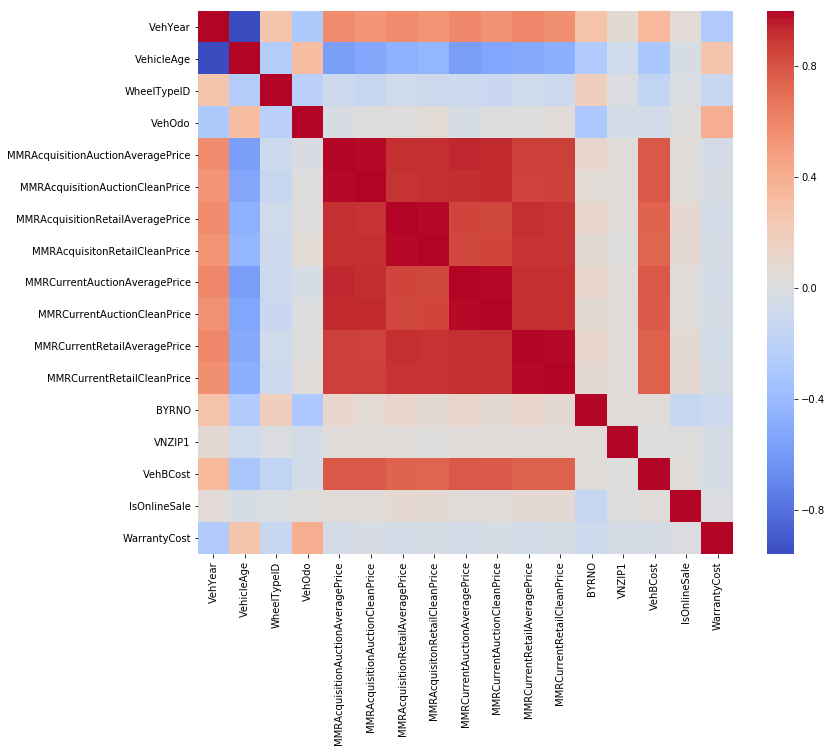

In [13]:
corr = train_df.drop(['RefId','IsBadBuy'],1).corr()
plt.figure(figsize = (12,10))
sb.heatmap(corr, cmap = sb.color_palette("coolwarm", 300))

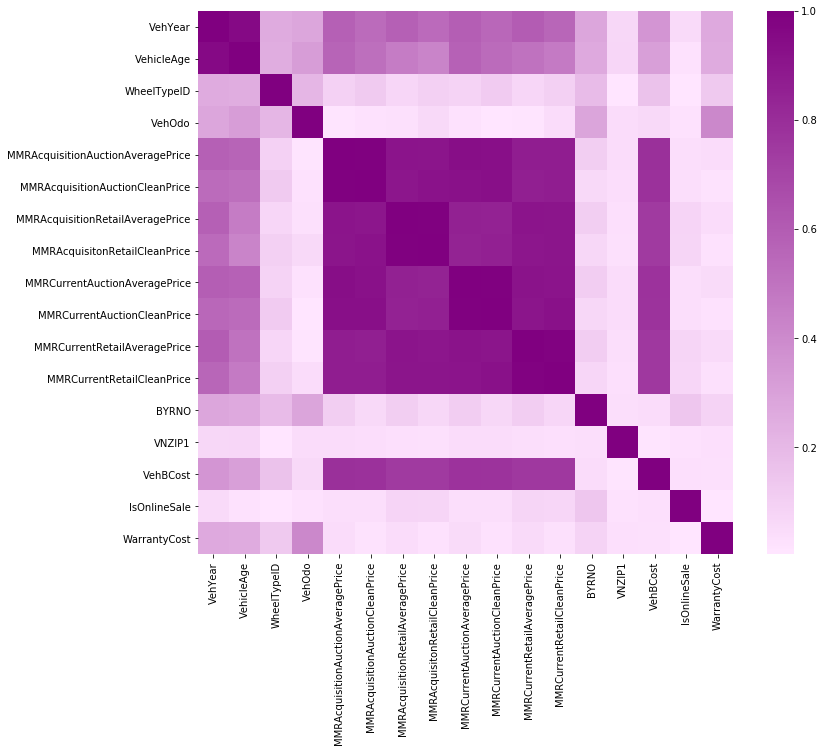

In [14]:
corr = train_df.drop(['RefId','IsBadBuy'],1).corr()
plt.figure(figsize = (12,10))
sb.heatmap(abs(corr), cmap = sb.light_palette("purple", 300))

#### Feature selection & data processing

1) Drop the RefID and BYRNO (not important features)

2) Drop PRIMEUNIT and AUCGUART, as they have a lot of missing values (69564 out of 72983)

3) Drop SubModel, too many categories

4) WheelTypeID is dropped as it gives identical information as WheelType does.

5) Drop VNST as VNZIP has already enclosed finer region information

6) Change PurchDate into a set of date columns, including dayofweek, month, quarter, year. The PurchDate will be dropped

7) Categorical data process, indicates the constraint on each of the features and later to change them into one-hot encoding.
    * WheelType, take all
    * Auction: all
    * VNZIP1: take top 50 + OTHER
    * Color: take top 5 + OTHER
    * Make : take top 20 + OTHER
    * Model: top 20 + OTHER
    * Trim: take top 10 + OTHER
    * Nationality: take all
    * Size: take all
    * TopThreeAmericanName: all
    * IsOnlineSale: all
 8) Scale the numerical data

In [15]:
train_df = pd.read_csv('data/training.csv')
test_df = pd.read_csv('data/test.csv')

In [16]:
helper.preprocess2(train_df)

In [17]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
IsBadBuy,72983.0,0.122988,0.328425,0.0,0.0,0.0,0.0,1.0
VehOdo,72983.0,71499.995917,14578.913128,4825.0,61837.0,73361.0,82436.0,115717.0
MMRAcquisitionAuctionAveragePrice,72983.0,6128.901347,2461.689193,0.0,4273.0,6097.0,7765.0,35722.0
MMRAcquisitionAuctionCleanPrice,72983.0,7373.618610,2722.156458,0.0,5407.0,7303.0,9021.0,36859.0
MMRAcquisitionRetailAveragePrice,72983.0,8497.021252,3155.896142,0.0,6281.0,8444.0,10650.0,39080.0
MMRAcquisitonRetailCleanPrice,72983.0,9850.912966,3385.372126,0.0,7494.0,9789.0,12088.0,41482.0
MMRCurrentAuctionAveragePrice,72983.0,6131.778812,2429.312427,0.0,4285.0,6062.0,7732.0,35722.0
MMRCurrentAuctionCleanPrice,72983.0,7390.346546,2680.450317,0.0,5425.0,7313.0,9006.0,36859.0
MMRCurrentRetailAveragePrice,72983.0,8775.521669,3084.027307,0.0,6550.0,8729.0,10897.0,39080.0
MMRCurrentRetailCleanPrice,72983.0,10145.202376,3303.104046,0.0,7796.0,10103.0,12308.0,41062.0


In [18]:
train_df.shape

(72983, 28)

In [19]:
train_df.columns

Index(['IsBadBuy', 'PurchDate', 'Auction', 'VehYear', 'Make', 'Trim', 'Color',
       'Transmission', 'WheelType', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VNST', 'VehBCost', 'WarrantyCost',
       'PurchYear', 'PurchMonth', 'PurchQuarter', 'PurchDayofweek'],
      dtype='object')

In [20]:
helper.preprocess2(test_df, train=False)

In [21]:
train_df.VNST.value_counts()

TX    13596
FL    10447
CA     7095
NC     7042
AZ     6174
CO     4998
SC     4280
OK     3594
GA     2450
TN     1764
VA     1662
MD     1158
UT      875
PA      847
OH      795
MO      758
AL      690
NV      562
IA      499
MS      493
IN      486
IL      458
LA      349
NJ      317
WV      292
NM      239
KY      230
OR      211
ID      196
WA      136
NH       97
AR       70
MN       62
NE       26
MA       15
MI       14
NY        6
Name: VNST, dtype: int64

## Model

In [22]:
SEED = 100

In [23]:
mapper = DataFrameMapper([
    ('Auction', LabelBinarizer()),
    ('VehYear', LabelBinarizer()),
#     (['VehicleAge'], StandardScaler()),
    ('Make',CountVectorizer(min_df=5000)),
#     ('Model', LabelBinarizer()),
    ('Trim', CountVectorizer(min_df=6500)),
    ('Color', CountVectorizer(min_df=6000)),
#     ('Transmission', LabelBinarizer()),
    ('WheelType', CountVectorizer(min_df=6000)),
    (['VehOdo'], StandardScaler()),
    ('Nationality', CountVectorizer(min_df=6000)),
    ('Size', TfidfVectorizer(min_df=5000)), # The only on use Tfidf originally
    ('TopThreeAmericanName', CountVectorizer(min_df=6000)),
    (['MMRAcquisitionAuctionAveragePrice'], StandardScaler()),
#     (['MMRAcquisitionAuctionCleanPrice'], StandardScaler()),
    (['MMRAcquisitionRetailAveragePrice'], StandardScaler()),
#     (['MMRAcquisitonRetailCleanPrice'], StandardScaler()),
    (['MMRCurrentAuctionAveragePrice'], StandardScaler()),
#     (['MMRCurrentAuctionCleanPrice'], StandardScaler()),
    (['MMRCurrentRetailAveragePrice'], StandardScaler()),
#     (['MMRCurrentRetailCleanPrice'], StandardScaler()),
    ('VNST', CountVectorizer(min_df=6000)),
    (['VehBCost'], StandardScaler()),
#     ('IsOnlineSale', LabelBinarizer()),
    (['WarrantyCost'], StandardScaler()),
    ('PurchYear', LabelBinarizer()),
    ('PurchMonth', LabelBinarizer()),
    ('PurchQuarter', LabelBinarizer()),
    ('PurchDayofweek', LabelBinarizer())])

In [24]:
train_df.PurchYear.value_counts()

2010    37922
2009    35061
Name: PurchYear, dtype: int64

In [25]:
X = mapper.fit_transform(train_df)
y = train_df['IsBadBuy']

In [26]:
X_test = mapper.transform(test_df)

In [27]:
print(X.shape)
print(X_test.shape)

(72983, 76)
(48707, 76)


Has increase the number of features from 32 to 187

In [28]:
## Split data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

check if the split conserves the inbalance property

In [29]:
print(y_tr.value_counts())
print(y_val.value_counts())

0    51166
1     7220
Name: IsBadBuy, dtype: int64
0    12841
1     1756
Name: IsBadBuy, dtype: int64


#### create a lgb classifier

In [30]:
d_train = lgb.Dataset(X_tr, label= y_tr)
d_valid = lgb.Dataset(X_val, label = y_val)

In [31]:
clf = lgb.LGBMClassifier(random_state=SEED)

In [32]:
param_grid = {
    "class_weight": [None, 'balanced'],
    "num_leaves":[30],
    "max_depth": [5, 10],
    "n_estimators": [30],
    "learning_rate" : [0.1],
    "reg_lambda": [0.1],
    "reg_alpha":[0.1],
    "scoring" :['f1']
             }

In [33]:
gbm = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1')

In [34]:
gbm.fit(d_train.data, d_train.label)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=100,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'class_weight': [None, 'balanced'], 'num_leaves': [30], 'max_depth': [5, 10], 'n_estimators': [30], 'learning_rate': [0.1], 'reg_lambda': [0.1], 'reg_alpha': [0.1], 'scoring': ['f1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [35]:
gbm.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 30,
 'num_leaves': 30,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'scoring': 'f1'}

In [36]:
gbm.best_score_

0.36605975043395433

In [37]:
skm.f1_score(d_valid.label, gbm.best_estimator_.predict(d_valid.data))

0.36384859096214772

#### Logistic Regression

In [38]:
lg_param_grid = {
    "C": [.05, 0.1, 1],
    'class_weight':[None, 'balanced']
}

In [39]:
lg = LogisticRegression(random_state=SEED)

In [40]:
lgs = GridSearchCV(estimator=lg, param_grid=lg_param_grid, scoring='f1')

In [41]:
lgs.fit(d_train.data, d_train.label)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 1], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [42]:
lgs.best_params_

{'C': 0.1, 'class_weight': 'balanced'}

In [43]:
skm.f1_score(d_valid.label, lgs.best_estimator_.predict(d_valid.data))

0.37037037037037041

#### wrap two best estimators

In [44]:
ests = {'gbm': gbm.best_estimator_, 'lg':lgs.best_estimator_}

In [45]:
label_ratio = train_df['IsBadBuy'].value_counts()[1]/len(train_df['IsBadBuy'])
label_ratio

0.12298754504473644

#### Plot the Precision-Recall Curve

In [84]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score, roc_auc_score

In [89]:
def plot_PRC(y_true, y_pred, model):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
#     average_precision = average_precision_score(y_true, y_pred)
#     plt.step(recall, precision,label = model+' (AP={0:0.2f})'.format(average_precision))
    AUC = auc(y_true, y_pred, reorder = True)
    plt.step(recall, precision,label = model+' (AUC={0:0.2f})'.format(AUC))
    plt.plot([0,1], [label_ratio, label_ratio], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.legend(loc="upper right")

def plot_ROC(y_true, y_pred, model):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc= roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label = model+' (ROC_AUC={0:0.2f})'.format(roc_auc))
    plt.scatter()
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC')
    plt.legend(loc="lower right")

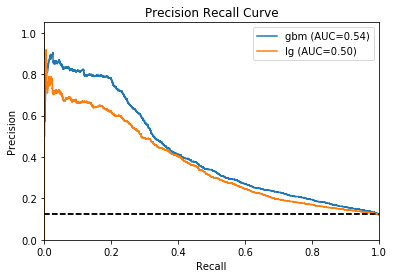

In [90]:
for c in ests:
    plot_PRC(d_valid.label, ests[c].predict_proba(d_valid.data)[:,1], c)

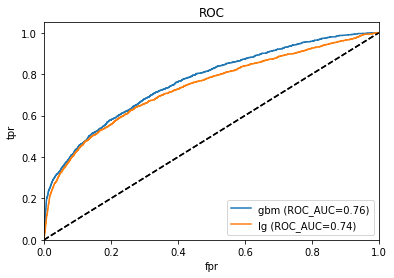

In [49]:
for c in ests:
    plot_ROC(d_valid.label, ests[c].predict_proba(d_valid.data)[:,1], c)

#### Try bigram

In [73]:
mapper2 = DataFrameMapper([
    ('Auction', LabelBinarizer()),
    ('VehYear', LabelBinarizer()),
#     (['VehicleAge'], StandardScaler()),
    ('Make',CountVectorizer(min_df=5000)),
#     ('Model', LabelBinarizer()),
    ('Trim', CountVectorizer(min_df=6500)),
    ('Color', CountVectorizer(min_df=6000)),
#     ('Transmission', LabelBinarizer()),
    ('WheelType', CountVectorizer(min_df=6000)),
    (['VehOdo'], StandardScaler()),
    ('Nationality', CountVectorizer(min_df=6000)),
    ('Size', TfidfVectorizer(min_df=5000, ngram_range=(1,2))), # The only on use Tfidf originally
    ('TopThreeAmericanName', CountVectorizer(min_df=6000)),
    (['MMRAcquisitionAuctionAveragePrice'], StandardScaler()),
#     (['MMRAcquisitionAuctionCleanPrice'], StandardScaler()),
    (['MMRAcquisitionRetailAveragePrice'], StandardScaler()),
#     (['MMRAcquisitonRetailCleanPrice'], StandardScaler()),
    (['MMRCurrentAuctionAveragePrice'], StandardScaler()),
#     (['MMRCurrentAuctionCleanPrice'], StandardScaler()),
    (['MMRCurrentRetailAveragePrice'], StandardScaler()),
#     (['MMRCurrentRetailCleanPrice'], StandardScaler()),
    ('VNST', CountVectorizer(min_df=6000)),
    (['VehBCost'], StandardScaler()),
#     ('IsOnlineSale', LabelBinarizer()),
    (['WarrantyCost'], StandardScaler()),
    ('PurchYear', LabelBinarizer()),
    ('PurchMonth', LabelBinarizer()),
    ('PurchQuarter', LabelBinarizer()),
    ('PurchDayofweek', LabelBinarizer())])

In [74]:
X2 = mapper.fit_transform(train_df)

In [77]:
X2_tr, X2_val, y2_tr, y2_val = train_test_split(X2, y, test_size=0.2, random_state=SEED)
d_train2 = lgb.Dataset(X2_tr, label= y2_tr)
d_valid2 = lgb.Dataset(X2_val, label = y2_val)

In [78]:
gbm2 = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1')

In [79]:
gbm2.fit(d_train2.data, d_train2.label)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=100,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'class_weight': [None, 'balanced'], 'num_leaves': [30], 'max_depth': [5, 10], 'n_estimators': [30], 'learning_rate': [0.1], 'reg_lambda': [0.1], 'reg_alpha': [0.1], 'scoring': ['f1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [80]:
gbm.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 30,
 'num_leaves': 30,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'scoring': 'f1'}

In [82]:
gbm.best_score_

0.36605975043395433

In [83]:
skm.f1_score(d_valid.label, gbm.best_estimator_.predict(d_valid.data))

0.36384859096214772

#### Feature importance

In [50]:
feature_imp_df = pd.DataFrame({'feat_name': mapper.transformed_names_, 'importance':gbm.best_estimator_.feature_importances_})

In [51]:
sort_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False)

In [52]:
sort_imp_df.head()

,feat_name,importance
50,VehBCost,83
28,VehOdo,72
41,MMRAcquisitionAuctionAveragePrice,51
51,WarrantyCost,50
1,Auction_MANHEIM,49


In [53]:
# list(sort_imp_df.feat_name.values)

([<matplotlib.axis.XTick at 0x1a211186a0>,
 <a list of 5 Text xticklabel objects>)

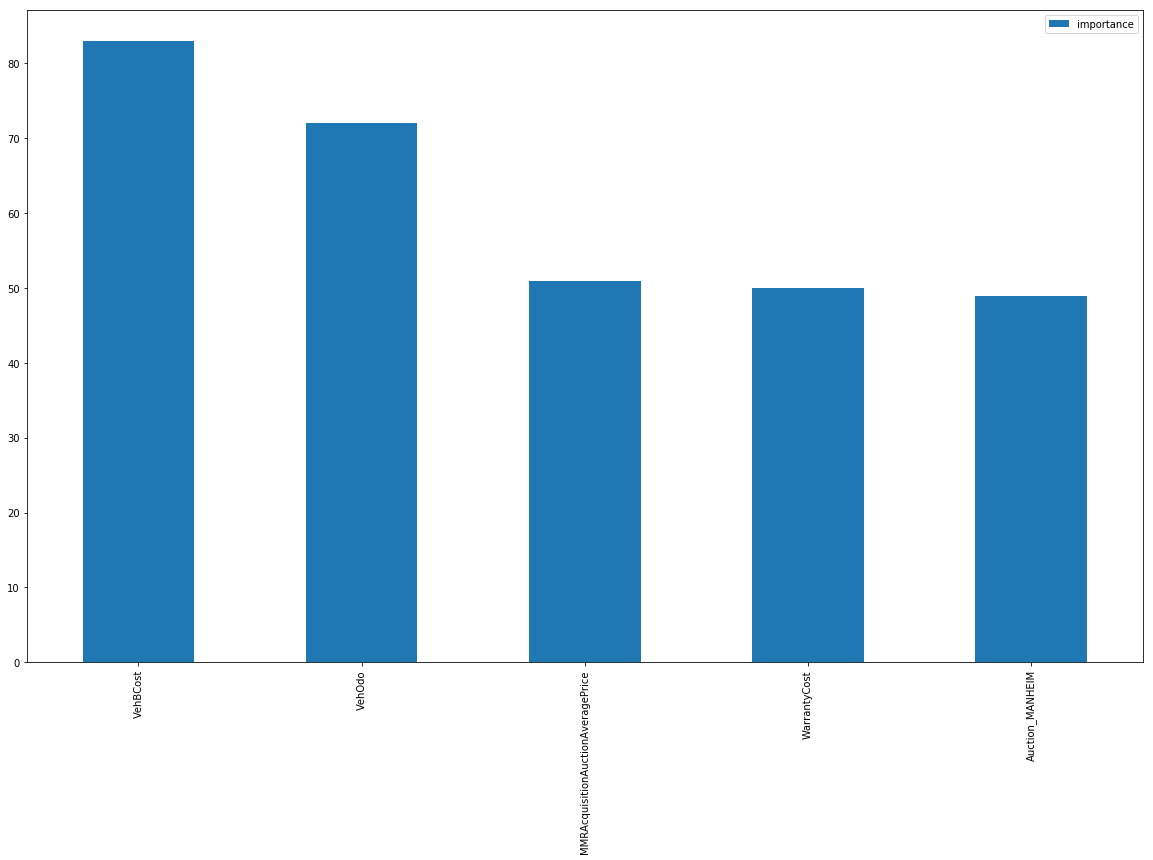

In [54]:
# plt.bar(range(len(gbm.best_estimator_.feature_importances_)), gbm.best_estimator_.feature_importances_)
# 
plt.figure()
sort_imp_df[:5].plot(kind='bar',figsize=(20,12))
plt.xticks(range(5), list(sort_imp_df.feat_name.values[:5]))

In [55]:
orig_feat_names = train_df.columns.tolist()
sort_imp_df['orig_feat'] = sort_imp_df['feat_name'].apply(lambda x: x.rsplit('_',1)[0]
                                                        if x.rsplit('_', 1)[0] in orig_feat_names else 
                                                        (x.split('_', 1)[0] if x.split('_',1)[0] in orig_feat_names else x))

([<matplotlib.axis.XTick at 0x1a2110ee10>,
 <a list of 21 Text xticklabel objects>)

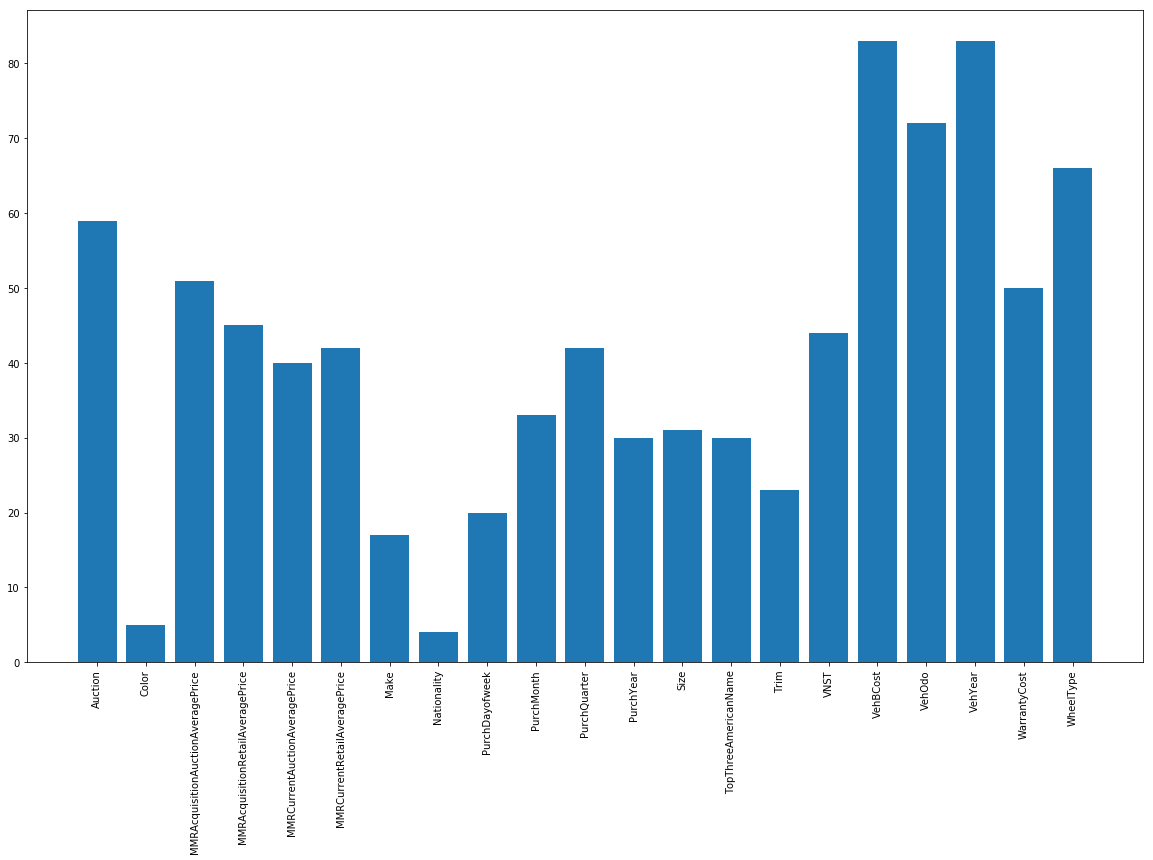

In [56]:
plt.figure(figsize=(20,12))
plt.bar(range(len(sort_imp_df.groupby('orig_feat').sum())), sort_imp_df.groupby('orig_feat').sum().importance.values)
plt.xticks(range(len(sort_imp_df.groupby('orig_feat').sum())), sort_imp_df.groupby('orig_feat').sum().importance.index, rotation='vertical')

##### check for datetime relations

([<matplotlib.axis.XTick at 0x1a12fac4e0>,
 <a list of 24 Text xticklabel objects>)

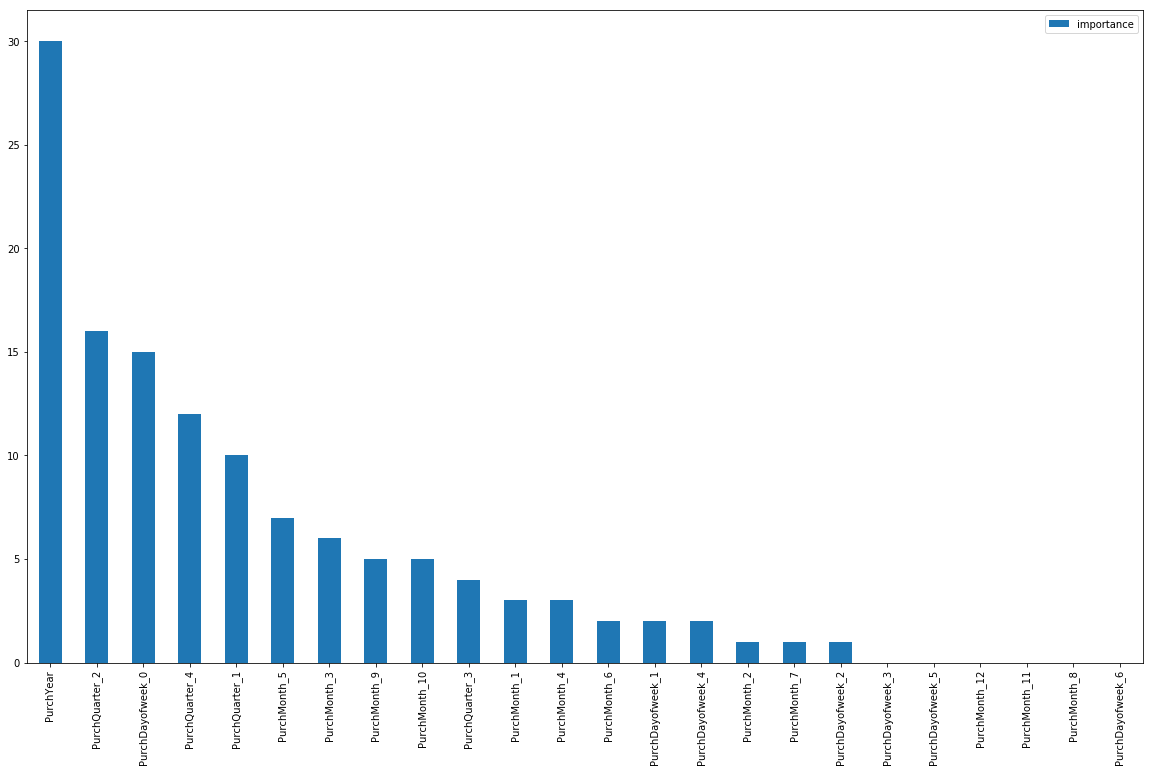

In [57]:
date_cols = [x for x in sort_imp_df.feat_name if 'Purch' in x]
a = sort_imp_df[sort_imp_df.feat_name.isin(date_cols)]
a.plot(kind='bar',figsize=(20,12))
plt.xticks(range(len(a)), list(a.feat_name.values))

In [58]:
ts = train_df[['PurchDate','IsBadBuy']]
ts.PurchDate = pd.to_datetime(ts.PurchDate)
ts = ts.set_index('PurchDate')

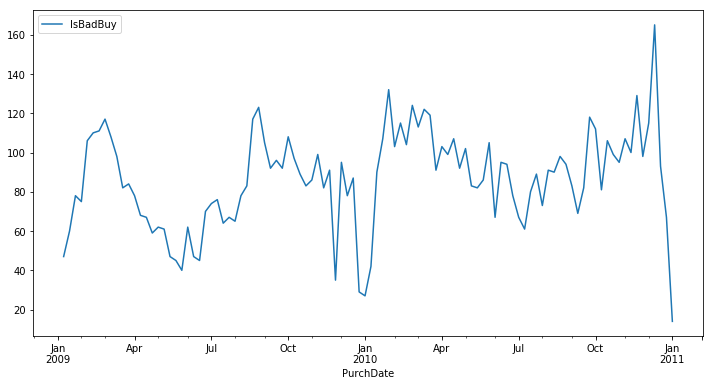

In [59]:
ts.resample("1W",how=np.sum).plot(figsize=(12,6))

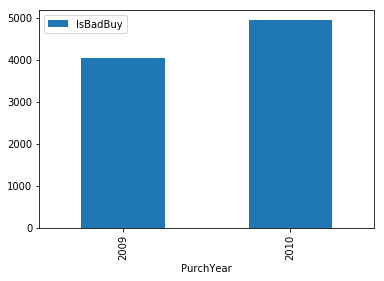

In [60]:
train_df[['PurchYear','IsBadBuy']].groupby('PurchYear').sum().plot(kind='bar')

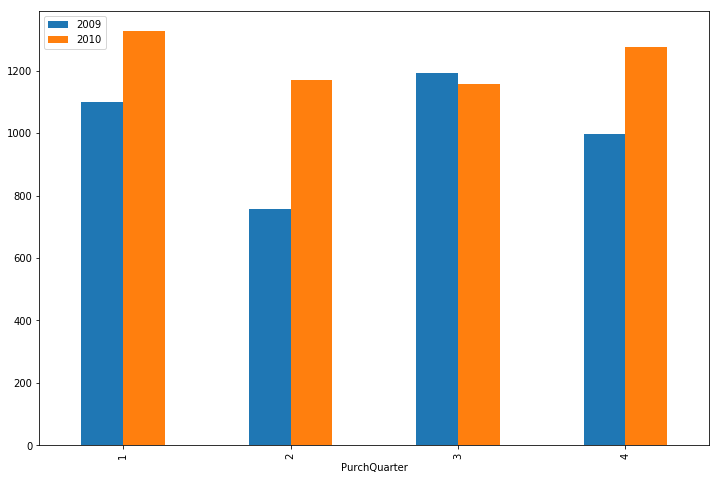

In [61]:
q_df = train_df[['PurchYear','PurchQuarter','IsBadBuy']].groupby(['PurchYear','PurchQuarter']).sum()
q_df2 = pd.merge(q_df.loc[2009],q_df.loc[2010], left_index=True, right_index=True, how='outer')
q_df2.columns= ['2009','2010']
q_df2.plot.bar(figsize=(12,8))

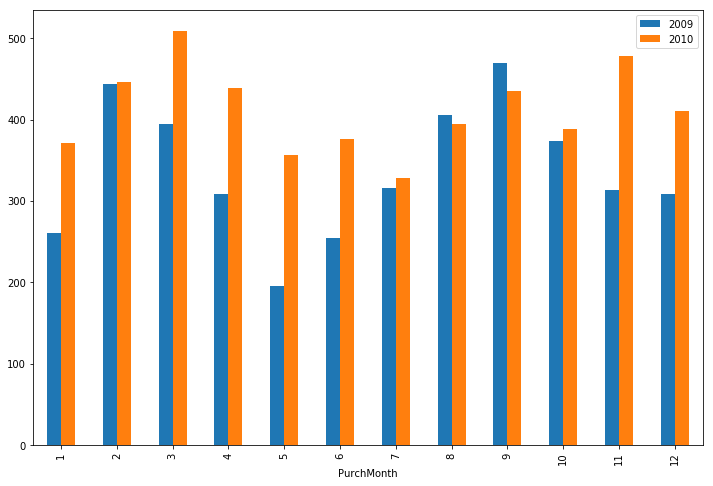

In [62]:
# train_df[['PurchYear','PurchMonth','IsBadBuy']].groupby(['PurchMonth']).sum().plot(kind ='bar')
# train_df[['PurchYear','PurchMonth','IsBadBuy']].groupby(['PurchYear','PurchMonth']).sum().plot(kind ='bar')
m_df = train_df[['PurchYear','PurchMonth','IsBadBuy']].groupby(['PurchYear','PurchMonth']).sum()
m_df2 = pd.merge(m_df.loc[2009],m_df.loc[2010], left_index=True, right_index=True, how='outer')
m_df2.columns = ['2009', '2010']
m_df2.plot.bar(figsize=(12,8))

In [63]:
d_df = train_df[['PurchYear','PurchDayofweek','IsBadBuy']].groupby(['PurchYear','PurchDayofweek']).sum()
# d_df2 = pd.merge(d_df.loc[2009],d_df.loc[2010], left_index=True, right_index=True, how='outer')
# d_df2.columns = ['2009', '2010']
# d_df2.plot.bar(figsize=(12,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a0b967a58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a0ce95e80>], dtype=object)

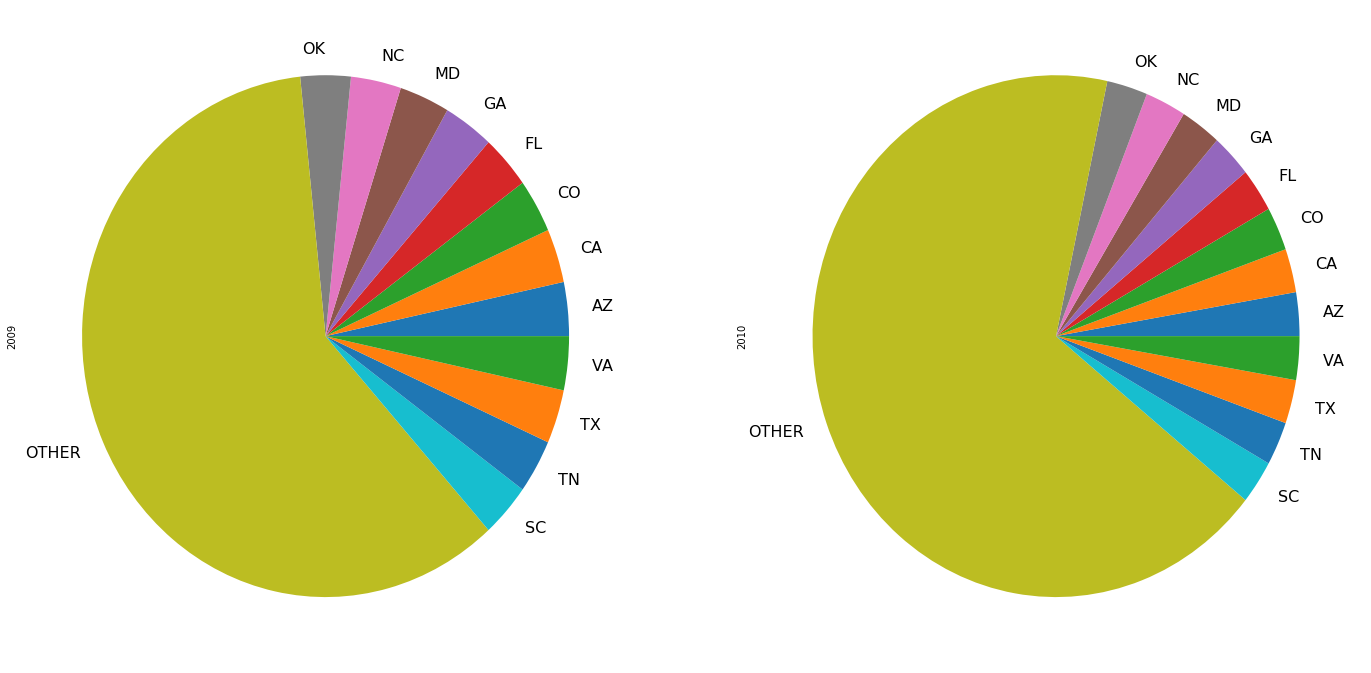

In [64]:
st_df = train_df[['PurchYear','VNST','IsBadBuy']].groupby(['PurchYear','VNST']).sum()
st_df2 = pd.merge(st_df.loc[2009],st_df.loc[2010], left_index=True, right_index=True, how='outer')
st_df2 = st_df2.reset_index()
st_df2.columns= ['VNST','2009','2010']
st_df2['VNST']= st_df2.apply(lambda x: x['VNST'] if (x['2009'] > 50 and x['2010'] > 50) else 'OTHER', axis=1)
st_df2.groupby('VNST').count().plot.pie(subplots=True, figsize=(24,12), legend = False, fontsize=16)

In [65]:
b = sort_imp_df[sort_imp_df.importance==0]
b.groupby('orig_feat').count()

,feat_name,importance
orig_feat,,
Color,3,3
PurchDayofweek,3,3
PurchMonth,3,3
Size,1,1
TopThreeAmericanName,1,1
VehYear,1,1


In [66]:
b

,feat_name,importance,orig_feat
72,PurchDayofweek_3,0,PurchDayofweek
12,VehYear_2010,0,VehYear
74,PurchDayofweek_5,0,PurchDayofweek
22,Color_grey,0,Color
64,PurchMonth_12,0,PurchMonth
63,PurchMonth_11,0,PurchMonth
40,TopThreeAmericanName_other,0,TopThreeAmericanName
23,Color_red,0,Color
60,PurchMonth_8,0,PurchMonth
24,Color_silver,0,Color


In [67]:
len(b)

12

#### create a submission

In [68]:
test = pd.read_csv('data/test.csv')

In [70]:
pd.DataFrame({"RefId": test.RefId, "IsBadBuy":ests['gbm'].predict_proba(X_test)[:,1]}, columns=['RefId','IsBadBuy']).to_csv("output2.csv", index=False)


Achieved a score of 0.23797 (~125th place/570 teams comapred to the 1st place 0.26719)

## Future work

1) use entity embedding to reduce the dimenstions increased by the dummy variables. Then use neural network as a model